# Problem 1: CNN-PDE Timing

The code from CNN-PDE.ipynb was copied into this notebook for timing tests.  Some slight alterations were made to the code to make it run with Tensorflow 2.4.  

In [1]:
#Import libraries for simulation
#import tensorflow as tf
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import time

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

import time

def DisplayArray(a, fmt='jpeg', rng=[0,1]):
    """Display an array as a picture."""
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    clear_output(wait = True)
    display(Image(data=f.getvalue()))

In [3]:
def make_kernel(a):
    """Transform a 2D array into a convolution kernel"""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1,1])
    return tf.constant(a, dtype=1)

def simple_conv(x, k):
    """A simplified 2D convolution operation"""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
    return y[0, :, :, 0]

In [4]:
def laplace_iso(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0.25, 0.5, 0.25],
                           [0.5, -3., 0.5],
                           [0.25, 0.5, 0.25]])
    return simple_conv(x, laplace_k)
def laplace(x):
    """Compute the 2D laplacian of an array"""
    laplace_k = make_kernel([[0., 1., 0.],
                           [1., -4., 1.],
                           [0., 1., 0.]])
    return simple_conv(x, laplace_k)

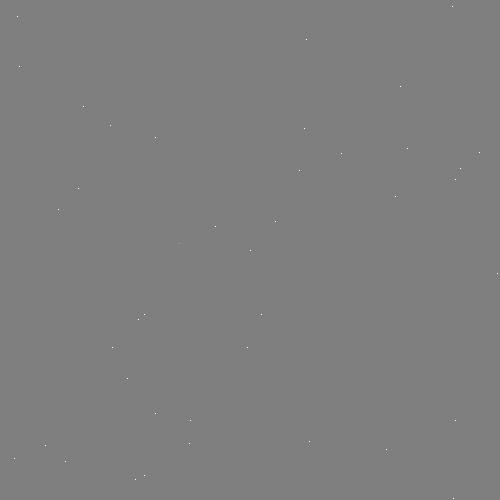

In [5]:
# more fun initial condition
for n in range(40):
    a,b = np.random.randint(0, N, 2)
    u_init[a,b] = np.random.uniform()
    
DisplayArray(u_init, rng=[-0.1, 0.1])

In [12]:
sess = tf.InteractiveSession()
#sess = tf.compat.v1.Session()

In [13]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
# c -- wave speed 
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())
c = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * ((c ** 2) * laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
    U.assign(U_),
    Ut.assign(Ut_))

# Initialize state to initial conditions
tf.global_variables_initializer().run()

In [14]:
# Run 1000 steps of PDE
steps = 1000
start = time.time()
for i in range(steps):
    # Step simulation
    step.run({eps: 0.03, damping: 0.04, c: 3.0})

elapsed = time.time() - start
print("Calculation time (N=500, n=1000) = "+str(elapsed)+" [s]")


Calculation time (N=500, n=1000) = 5.185168743133545 [s]


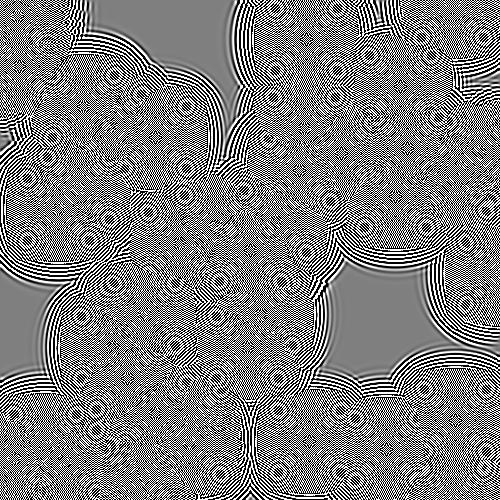

In [9]:
# Run 1000 steps of PDE
steps = 1000
step_times = []
for i in range(steps):
    # Step simulation
    start_step = time.time()
    step.run({eps: 0.03, damping: 0.04, c: 3.0})
    step_times.append(time.time() - start_step)
    DisplayArray(U.eval(), rng=[-0.1, 0.1])

Text(0.5, 1.0, 'Calculation Time per Step')

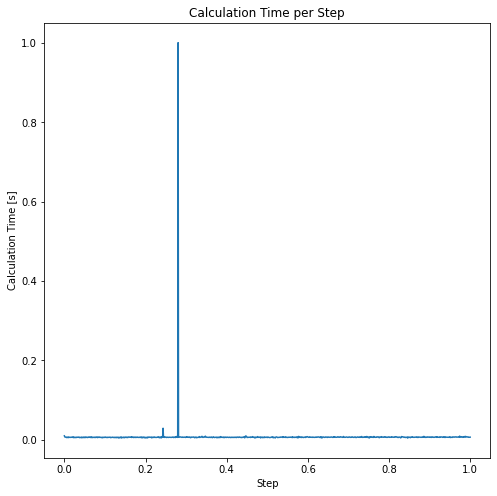

In [13]:
import matplotlib.pyplot as plt
step_times = np.array(step_times)
steps_data = np.linspace(0,1,steps)
plt.figure(1,figsize=(8,8))
plt.plot(steps_data, step_times)
plt.xlabel("Step")
plt.ylabel("Calculation Time [s]")
plt.title("Calculation Time per Step")

In [11]:
# Run 1000 steps of PDE
start = time.time()
for i in range(1000):
    # Step simulation
    step.run({eps: 0.03, damping: 0.04, c: 3.0})
    DisplayArray(U.eval(), rng=[-0.1, 0.1])

elapsed = time.time() - start
print(elapsed)
sess.close()

44.293107986450195


### Rerun the code without DisplayArray function

The calculation was run a second time to see how much of an impact the DisplayArray function has on loop time. 

In [15]:
sess = tf.InteractiveSession()
#sess = tf.compat.v1.Session()

# Parameters:
# eps -- time resolution
# damping -- wave damping
# c -- wave speed 
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())
c = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * ((c ** 2) * laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
    U.assign(U_),
    Ut.assign(Ut_))

# Initialize state to initial conditions
tf.global_variables_initializer().run()

# Run 1000 steps of PDE
start = time.time()
for i in range(1000):
    # Step simulation
    step.run({eps: 0.03, damping: 0.04, c: 3.0})

elapsed_2 = time.time() - start
print(elapsed_2)
sess.close()

12.40937352180481


In [17]:
print("Loop with DisplayArray    = "+str(elapsed)+" [s]")
print("Loop without DisplayArray = "+str(elapsed_2)+" [s]")

Loop with DisplayArray    = 44.293107986450195 [s]
Loop without DisplayArray = 12.40937352180481 [s]


### Comments

Based on the runtimes, shown above, the function *DisplayArray()* adds a considerable amount of time to the stepping loop.